# Environment Import

In [4]:
import time

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, collect_list, split, explode
from pyspark.sql.functions import udf

# Part 1: Init Spark Session with Ratings

In [5]:
def init_spark_session_with_ratings(filename):
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Args:
    filename (str): The path to the ratings file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.driver.memory", "8G") \
        .getOrCreate()

    # Retrieve SparkContext from SparkSession
    sc = spark.sparkContext
    # sc.setLogLevel("INFO")

    # Load the data into an RDD
    ratings_rdd = sc.textFile(filename)

    # Remove the header from the RDD and parse each line into a tuple
    header = ratings_rdd.first()
    ratings_rdd = (ratings_rdd.filter(lambda line: line != header)
                   .map(lambda line: line.split(','))
                   .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]), tokens[3])))

    num_ratings = ratings_rdd.count()
    print(f"Number of ratings: {num_ratings}")

    # Convert RDD to DataFrame for easier processing
    ratings_df = spark.createDataFrame(ratings_rdd, ["userId", "movieId", "rating", "timestamp"])

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings("dataset/ratings.csv")
print(ratings_df)

Number of ratings: 25000095
DataFrame[userId: bigint, movieId: bigint, rating: double, timestamp: string]


# Part 2: Basic Recommend with Visualization

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
| 133307|        5.0|
| 205419|        5.0|
| 169816|        5.0|
| 165787|        5.0|
| 160028|        5.0|
+-------+-----------+



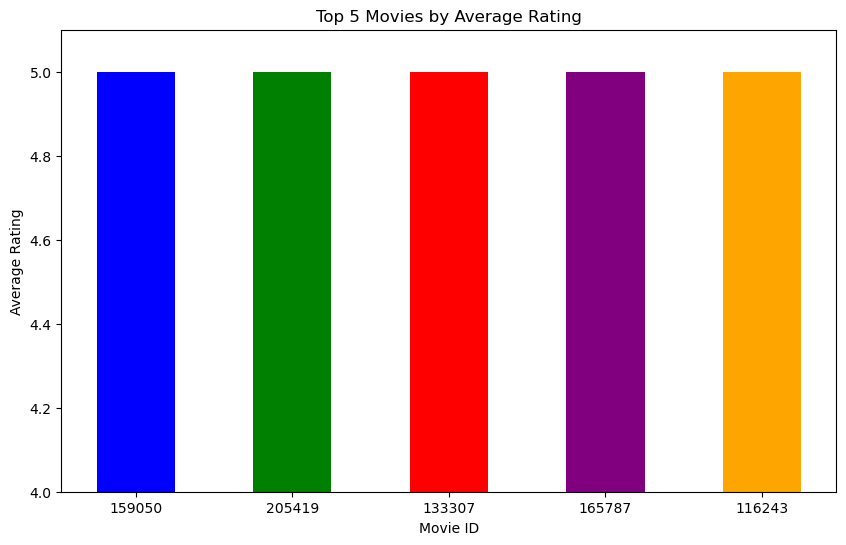

In [6]:
def basic_recommend(spark, ratings_df):
    """
    Performs basic movie recommendation based on the average rating.

    Args:
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Compute the average rating for each movie
    avg_ratings_df = ratings_df.groupBy("movieId").avg("rating")

    # Retrieve top 5 movies based on average ratings
    top_movies = avg_ratings_df.orderBy("avg(rating)", ascending=False).limit(5)
    top_movies.show()

    # Plotting the top 5 movies and save the figure to a file
    top_movies_pd = top_movies.toPandas()   # Convert Spark DataFrame to Pandas DataFrame for plotting
    plt.figure(figsize=(10, 6))
    # Adding width to the bars and making them visually distinct
    plt.bar(top_movies_pd['movieId'].astype(str), top_movies_pd['avg(rating)'], width=0.5, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.xlabel('Movie ID')
    plt.ylabel('Average Rating')
    plt.title('Top 5 Movies by Average Rating')
    plt.ylim(4, 5.1)  # Ensuring that the top of the bars are within the visible range of the plot
    plt.show()
    plt.close()  # Close the plt object to free memory

basic_recommend(spark, ratings_df)

# Part3: ALS Recommend with Visualization

   rank  maxIter  regParam      RMSE       MAE  Training Time
0    10        5      0.01  0.822638  0.630378      69.868859
1    10        5      0.10  0.825636  0.644511      69.552677
2    10       10      0.01  0.808095  0.616031      77.373175
3    10       10      0.10  0.813549  0.631021      77.465709
4    20        5      0.01  0.820101  0.624476      81.730175
5    20        5      0.10  0.834892  0.656994      80.007096
6    20       10      0.01  0.813431  0.616101      99.531461
7    20       10      0.10  0.813631  0.633039      94.973497
Best Parameters: (10, 10, 0.01)
Best RMSE: inf


+------+----------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                           |
+------+----------------------------------------------------------------------------------------------------------+
|31    |[{185659, 13.202439}, {169896, 11.108482}, {185653, 10.546553}, {156573, 7.4271574}, {200986, 7.367985}]  |
|34    |[{171059, 15.594081}, {160183, 10.813658}, {151443, 10.532187}, {126941, 10.3864565}, {182759, 10.351672}]|
|53    |[{185659, 21.111715}, {169896, 18.189604}, {185653, 17.224836}, {200986, 14.802373}, {156573, 13.217228}] |
|65    |[{193489, 11.56413}, {147292, 11.457008}, {205453, 11.213605}, {189455, 10.729432}, {146146, 10.64672}]   |
|78    |[{171059, 16.074059}, {168906, 14.907032}, {160183, 13.492821}, {182759, 13.430552}, {86952, 11.645046}]  |
|85    |[{168906, 24.012201}, {182759, 22.750895}, {200986, 19.096811}, 

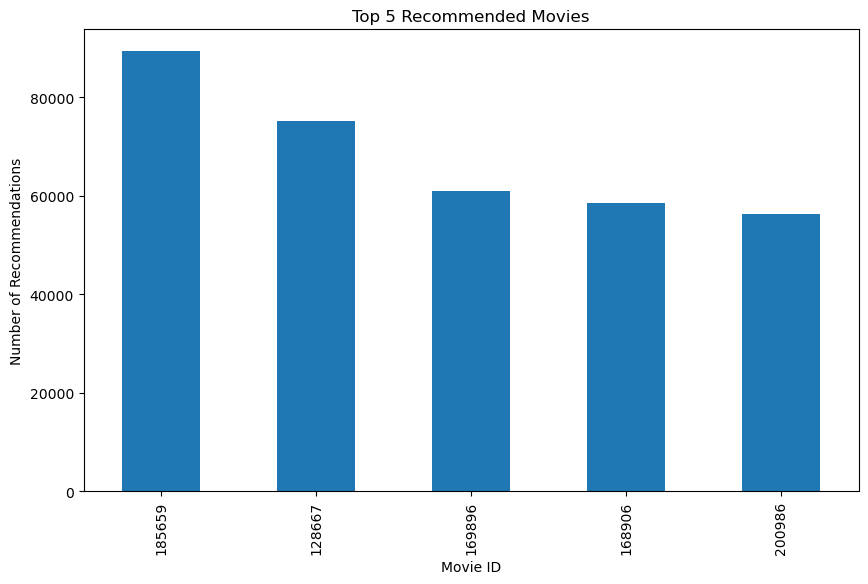

In [9]:
def als_recommend(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares).

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Create an ALS model
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

    # Define a grid of parameters for tuning
    param_grid = {
        "rank": [10, 20],
        "maxIter": [5, 10],
        "regParam": [0.01, 0.1]
    }

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Variables to keep track of the best model and its performance
    best_rmse = float('inf')
    best_model = None
    best_error = float('inf')
    best_params = None
    results = []

    # Grid search through the parameter space
    for rank in param_grid["rank"]:
        for max_iter in param_grid["maxIter"]:
            for reg_param in param_grid["regParam"]:
                start_time = time.time()

                # Set model parameters
                als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)
                
                # Fit ALS model on training data
                model = als.fit(training)
                
                # Evaluate the model on test data
                predictions = model.transform(test)
                rmse = rmse_evaluator.evaluate(predictions)
                mae = mae_evaluator.evaluate(predictions)
                training_time = time.time() - start_time

                # Append results
                results.append({
                    "rank": rank, "maxIter": max_iter, "regParam": reg_param,
                    "RMSE": rmse, "MAE": mae, "Training Time": training_time
                })

                # Update best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = (rank, max_iter, reg_param)

    # Save the results DataFrame to a CSV file
    results_df = pd.DataFrame(results)
    print(results_df)

    # Display the best model parameters and its RMSE
    print("Best Parameters:", best_params)
    print("Best RMSE:", best_error)

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = best_model.recommendForAllUsers(5)
    recommendations.show(truncate=False)

    # Explode the recommendations to create a row for each movie
    recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")).select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))

    # Plotting the number of times each movie is recommended
    recs_pd = recs_exploded.toPandas()
    plt.figure(figsize=(10, 6))
    recs_pd['movieId'].value_counts().head(5).plot(kind='bar')
    plt.xlabel('Movie ID')
    plt.ylabel('Number of Recommendations')
    plt.title('Top 5 Recommended Movies')
    plt.show()
    plt.close()


als_recommend(spark, ratings_df)

23/11/27 06:56:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Square Error (RMSE): 0.8077593987849365
Mean Absolute Error (MAE): 0.61236225478502


+------+---------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                          |
+------+---------------------------------------------------------------------------------------------------------+
|31    |[{116847, 6.533978}, {155113, 6.1453342}, {149508, 6.099179}, {61707, 5.657712}, {119909, 5.4521785}]    |
|34    |[{182759, 11.159067}, {72388, 10.862688}, {171781, 9.994989}, {116036, 9.8924265}, {145787, 9.000381}]   |
|53    |[{116847, 11.31352}, {90533, 10.482658}, {172635, 10.258764}, {61707, 10.210754}, {116179, 10.015746}]   |
|65    |[{178079, 17.101349}, {82362, 16.587847}, {129364, 16.350992}, {96257, 15.943913}, {65667, 15.727347}]   |
|78    |[{76022, 9.185687}, {116179, 8.994229}, {171877, 8.957512}, {187215, 8.935819}, {207888, 8.857932}]      |
|85    |[{182759, 14.145891}, {187167, 12.58505}, {120274, 12.178319}, {184795, 

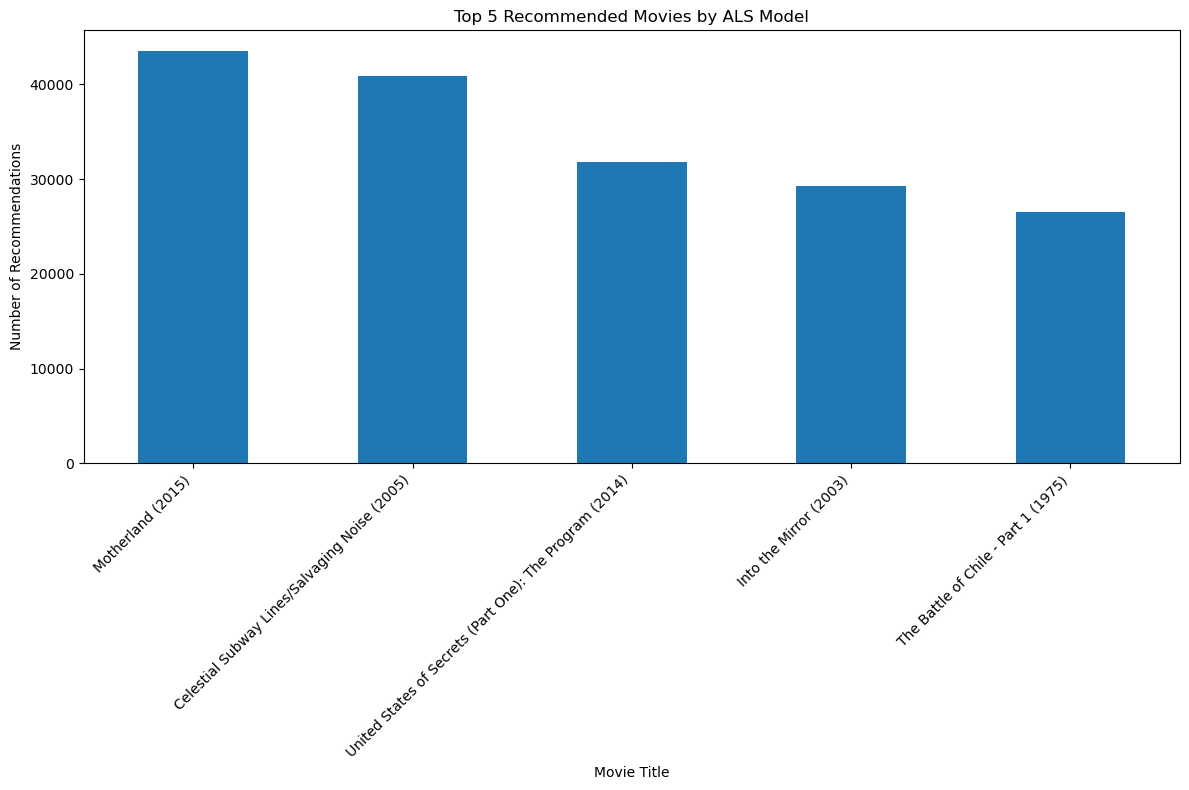

In [10]:
def als_recommend_best(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares) model with optimal parameters.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Create an ALS model
    als = ALS(rank=10,maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
   
    # Fit ALS model on training data
    model = als.fit(training)

    # Evaluate the model on test data
    predictions = model.transform(test)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = model.recommendForAllUsers(5)
    recommendations.show(truncate=False)

    # Prepare data for visualization
    recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")).select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)    # Movies: movieId, title, genres
    recs_joined = recs_exploded.join(movies_df, "movieId").select("userId", "title", "rating")
    recs_pd = recs_joined.toPandas()

    # Count the number of recommendations for each movie and get the top 5
    top_movies = recs_pd['title'].value_counts().head(5)

    # Plotting the number of times each movie is recommended using the movie titles
    plt.figure(figsize=(12, 8))
    top_movies.plot(kind='bar')
    plt.xlabel('Movie Title')  # Changed from 'Movie ID' to 'Movie Title'
    plt.ylabel('Number of Recommendations')
    plt.title('Top 5 Recommended Movies by ALS Model')
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust the layout to fit the labels
    plt.show()
    plt.close()


als_recommend_best(spark, ratings_df)

# Part 3: RF Recommend with Visualization

In [13]:
def feature_engineering(spark, ratings_df):
    """
    Perform feature engineering for movie recommendations. This includes processing movie genres and tags,
    and applying one-hot encoding.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.

    Returns:
    DataFrame: A DataFrame with combined movie features ready for model training.
    """

    # Converts a list of vectors into a single vector by summing up each dimension.
    def sum_vectors(vectors):
        return Vectors.dense(sum(v[0] for v in vectors))
    
    sum_vectors_udf = udf(sum_vectors, VectorUDT())

    # Load and preprocess datasets
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)    # movieId, title, genres
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)    # userId, movieId, tag, timestamp
    print("Initial Movies DataFrame:", movies_df.take(5))
    print("Initial Tags DataFrame:", tags_df.take(5))

    # Process genres: split, explode, and one-hot encode
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))    # Split genres into individual genres
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))   # Explode genres into new rows
    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)
    print("Movies DataFrame after splitting genres:", movies_df.take(5))
    print("Movies DataFrame after splitting and exploding genres:", movies_exploded.take(5))
    print("Indexed Genre DataFrame:", indexed_genre.take(5))
    print("Encoded Genre DataFrame:", encoded_genre.take(5))

    # Aggregate the encoded genres back to movie level
    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
    print("Aggregated Genre DataFrame:", genre_aggregated.take(5))

    # Process tags using StringIndexer + OneHotEncoder
    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(tags_df)
    indexed_tags = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tags_encoded = tag_encoder.fit(indexed_tags).transform(indexed_tags)
    print("Indexed Tags DataFrame:", indexed_tags.take(5))
    print("Encoded Tags DataFrame:", tags_encoded.take(5))

    # Explode tag vectors into a list of features for each movie
    movie_tags_features = tags_encoded.groupBy('movieId').agg(F.collect_list('tagVec').alias('tagVectors'))
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors')).drop('tagVectors')
    print("Movie Tags Features DataFrame:", movie_tags_features.take(5))

    # Combine movie features with ratings
    complete_data_df = ratings_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId").join(movie_tags_features, "movieId")
    print("Complete Data DataFrame after combining features with ratings:", complete_data_df.take(5))

    # Create feature vectors
    assembler = VectorAssembler(inputCols=["genresVec", "tagFeatures"], outputCol="features")
    data_ready = assembler.transform(complete_data_df)

    return data_ready


data_ready = feature_engineering(spark, ratings_df)
print(data_ready)

Initial Movies DataFrame: [Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'), Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'), Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'), Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'), Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]
Initial Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355'), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256'), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598'), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604'), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455')]
Movies DataFrame after splitting genres: [Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', split_genres=['Adventure', 'Animation', 'Children

Aggregated Genre DataFrame: [Row(movieId=1, genreVecList=[SparseVector(19, {9: 1.0}), SparseVector(19, {12: 1.0}), SparseVector(19, {11: 1.0}), SparseVector(19, {1: 1.0}), SparseVector(19, {14: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=2, genreVecList=[SparseVector(19, {9: 1.0}), SparseVector(19, {11: 1.0}), SparseVector(19, {14: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=3, genreVecList=[SparseVector(19, {1: 1.0}), SparseVector(19, {3: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=4, genreVecList=[SparseVector(19, {1: 1.0}), SparseVector(19, {0: 1.0}), SparseVector(19, {3: 1.0})], genresVec=DenseVector([1.0])), Row(movieId=5, genreVecList=[SparseVector(19, {1: 1.0})], genresVec=DenseVector([0.0]))]


23/11/27 07:17:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Indexed Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355', tagIndex=19.0), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256', tagIndex=0.0), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598', tagIndex=10.0), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604', tagIndex=502.0), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455', tagIndex=647.0)]


23/11/27 07:17:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Encoded Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355', tagIndex=19.0, tagVec=SparseVector(73050, {19: 1.0})), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256', tagIndex=0.0, tagVec=SparseVector(73050, {0: 1.0})), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598', tagIndex=10.0, tagVec=SparseVector(73050, {10: 1.0})), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604', tagIndex=502.0, tagVec=SparseVector(73050, {502: 1.0})), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455', tagIndex=647.0, tagVec=SparseVector(73050, {647: 1.0}))]


23/11/27 07:17:18 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:17:20 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Movie Tags Features DataFrame: [Row(movieId=31, tagFeatures=DenseVector([0.0])), Row(movieId=34, tagFeatures=DenseVector([0.0])), Row(movieId=53, tagFeatures=DenseVector([0.0])), Row(movieId=65, tagFeatures=DenseVector([0.0])), Row(movieId=78, tagFeatures=DenseVector([0.0]))]


23/11/27 07:17:21 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:17:23 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Complete Data DataFrame after combining features with ratings: [Row(movieId=29, userId=3, rating=4.5, timestamp='1484754967', genresVec=DenseVector([1.0]), tagFeatures=DenseVector([4.0])), Row(movieId=3091, userId=3, rating=4.0, timestamp='1484754262', genresVec=DenseVector([1.0]), tagFeatures=DenseVector([0.0])), Row(movieId=60756, userId=3, rating=3.5, timestamp='1439474134', genresVec=DenseVector([0.0]), tagFeatures=DenseVector([0.0])), Row(movieId=71530, userId=3, rating=3.5, timestamp='1484756216', genresVec=DenseVector([0.0]), tagFeatures=DenseVector([27.0])), Row(movieId=72011, userId=3, rating=4.0, timestamp='1439473373', genresVec=DenseVector([1.0]), tagFeatures=DenseVector([0.0]))]


23/11/27 07:17:46 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:17:47 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


DataFrame[movieId: bigint, userId: bigint, rating: double, timestamp: string, genresVec: vector, tagFeatures: vector, features: vector]


23/11/27 07:17:57 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2117 (TID 5012): Attempting to kill Python Worker


23/11/27 07:27:30 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:27:32 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:27:39 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/27 07:27:48 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/27 07:28:13 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/27 07:28:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/27 07:28:56 WARN MemoryStore: Not enough space to cache rdd_2782_6 in memory! (computed 67.3 MiB so far)
23/11/27 07:28:56 WARN MemoryStore: Not enough space to cache rdd_2782_1 in memory! (computed 105.2 MiB so far)
23/11/27 07:28:56 WARN MemoryStore: Not enough space to cache rdd_2782_11 in memory! (computed 67.3 MiB so far)
23/11/27 07:28:56 WARN MemoryStore: Not enough space to cache rdd_2782_2 in memory! (computed 67.3 MiB so far)
23/11/27 07:28:56 WARN MemoryStore: No

Root Mean Square Error (RMSE): 1.0475513198788562
Mean Absolute Error (MAE): 0.8343506402621962
DataFrame[title: string, prediction: double]


23/11/27 07:31:06 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:31:07 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:31:14 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/27 07:31:39 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


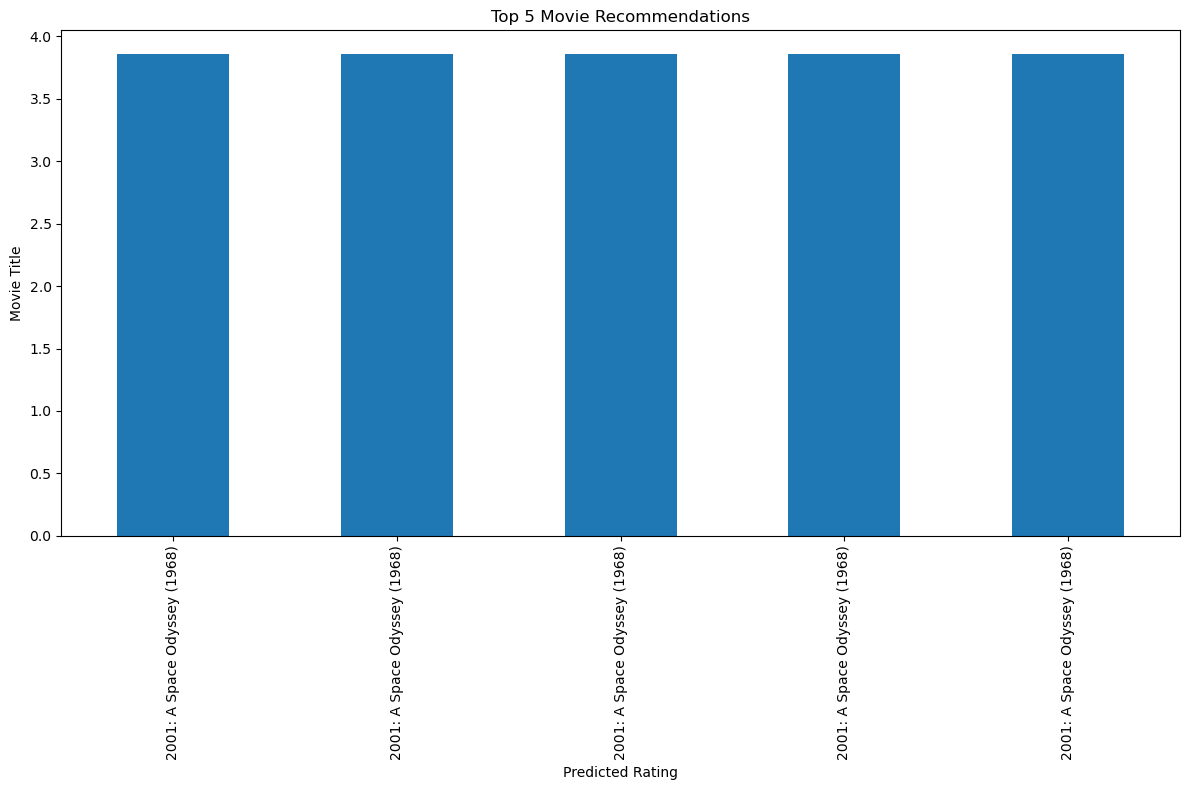

In [14]:
def train_evaluate_visualize(data_ready):
    """
    Train, evaluate, and visualize movie recommendations using a Random Forest model.

    Args:
    data_ready (DataFrame): DataFrame containing prepared features for training.
    """

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model
    rf = RandomForestRegressor(featuresCol="features", labelCol="rating")
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Get top5 movie recommendations
    top_predictions = predictions_df.orderBy('prediction', ascending=False).limit(5)

    # Join with the movies dataframe to get movie titles
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'prediction')
    print(top_movies_with_titles)

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['prediction'].plot(kind='bar')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()


train_evaluate_visualize(data_ready)

# Part 4: Model Comparison

**ALS model**:
+ Advantages: It is suitable for large-scale data sets, can effectively handle sparsity problems, and is often used in recommendation systems.
+ Disadvantages: Need to adjust multiple parameters, sensitive to cold start issues.

**Random forest model**:
+ Advantages: It handles nonlinear relationships well and is less prone to overfitting.
+ Disadvantages: A large amount of feature engineering is required and the computational cost is high.